# 09b: Reservoir Filling Forecasting — NO_5 (Bergen)

**Phase 3** — Machine learning reservoir filling forecasting using gradient boosted trees.

This notebook predicts **reservoir filling levels** (% full, 0–100) for NO_5 (Bergen)
using weather data, commodity prices, calendar patterns, load/generation data, and
historical filling patterns.

**Why forecast reservoir filling?**
Norway's electricity supply is ~95% hydropower. Reservoir levels are a leading indicator
for electricity prices — low reservoirs signal scarcity risk and higher future prices.
By forecasting reservoir filling, we can anticipate supply-side pressures before they
show up in prices.

**Key challenge — weekly data forward-filled to hourly:**
NVE publishes reservoir data weekly. In our feature matrix, this is forward-filled
to hourly resolution. The target changes only once per week, so the model must
learn the slow dynamics of reservoir filling from faster-moving signals (weather,
production, consumption).

**LEAKAGE PREVENTION:**
We must drop features derived directly from the target:
- `reservoir_filling_twh` — absolute filling (monotonic transform of %)
- `reservoir_filling_change` — week-over-week change (diff of target)
- `reservoir_vs_median` — deviation from median (function of target)
- `reservoir_vs_min` — deviation from min (function of target)

**Methods:**
1. Naive baseline (same week last year)
2. XGBoost
3. LightGBM
4. CatBoost
5. Weighted ensemble (inverse-MAE)
6. Walk-forward validation (6-fold)
7. SHAP feature importance analysis
8. Yr weather forecast integration (forward-looking predictions)

**Data split:**
- Training: 2022-01-01 to 2024-12-31 (~26,280 hours)
- Validation: 2025-01-01 to 2025-06-30 (~4,344 hours)
- Test: 2025-07-01 to 2026-02-22

In [1]:
import sys
import logging
import warnings
import time
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy import stats

# Project imports
sys.path.insert(0, str(Path.cwd().parent))
from src.models.forecasters import NaiveForecaster
from src.models.train import (
    MLPriceForecaster,
    prepare_ml_features,
    walk_forward_validate,
    train_ensemble,
    forecast_with_yr,
)
from src.models.evaluate import compute_metrics, comparison_table, plot_forecast, plot_residuals
from src.data.fetch_yr_forecast import fetch_yr_forecast

warnings.filterwarnings("ignore")
logging.basicConfig(level=logging.INFO, format="%(asctime)s %(name)s %(levelname)s %(message)s")

%matplotlib inline
plt.rcParams["figure.figsize"] = (16, 5)
plt.rcParams["figure.dpi"] = 100

ZONE = "NO_5"
TARGET_COL = "reservoir_filling_pct"

# Leakage columns — derived directly from the target
LEAKAGE_COLS = [
    "reservoir_filling_twh",
    "reservoir_filling_change",
    "reservoir_vs_median",
    "reservoir_vs_min",
]

print(f"Forecasting target: {TARGET_COL} for {ZONE} (Bergen)")
print(f"Leakage columns to drop: {LEAKAGE_COLS}")

Forecasting target: reservoir_filling_pct for NO_5 (Bergen)
Leakage columns to drop: ['reservoir_filling_twh', 'reservoir_filling_change', 'reservoir_vs_median', 'reservoir_vs_min']


In [2]:
# Load feature matrix
data_path = Path.cwd().parent / "data" / "processed" / "features_NO_5_2022-01-01_2026-01-01.parquet"
df = pd.read_parquet(data_path)
print(f"Loaded: {df.shape[0]:,} rows x {df.shape[1]} columns")
print(f"Date range: {df.index.min()} to {df.index.max()}")

# Extract target
target = df[TARGET_COL]

# Truncate at 2026-02-22 (end of available verified data)
cutoff = pd.Timestamp("2026-02-22", tz="Europe/Oslo")
df = df[df.index <= cutoff]
target = target[target.index <= cutoff]
print(f"After truncation: {len(target):,} hours ({target.index.min()} to {target.index.max()})")

# Data quality check
print(f"\nData quality for {TARGET_COL}:")
print(f"  NaN count: {target.isna().sum()}")
print(f"  Min: {target.min():.1f}%")
print(f"  Max: {target.max():.1f}%")
print(f"  Mean: {target.mean():.1f}%")
print(f"  Std: {target.std():.1f}%")

# Weekly data forward-filled to hourly: count unique values
n_unique = target.nunique()
n_weeks = len(target) / 168
print(f"  Unique values: {n_unique} (≈{n_weeks:.0f} weeks of data)")
print(f"  Note: NVE publishes weekly — {n_unique} distinct levels across {len(target):,} hours")

# Year-by-year summary
print("\nYearly summary:")
for year in range(2022, 2026):
    mask = target.index.year == year
    yearly = target[mask]
    print(f"  {year}: {len(yearly):>5,} hours, "
          f"mean={yearly.mean():.1f}%, std={yearly.std():.1f}%, "
          f"min={yearly.min():.1f}%, max={yearly.max():.1f}%")

Loaded: 35,065 rows x 63 columns
Date range: 2022-01-01 00:00:00+01:00 to 2026-01-01 00:00:00+01:00
After truncation: 35,065 hours (2022-01-01 00:00:00+01:00 to 2026-01-01 00:00:00+01:00)

Data quality for reservoir_filling_pct:
  NaN count: 24
  Min: 0.1%
  Max: 0.9%
  Mean: 0.6%
  Std: 0.2%
  Unique values: 209 (≈209 weeks of data)
  Note: NVE publishes weekly — 209 distinct levels across 35,065 hours

Yearly summary:
  2022: 8,760 hours, mean=0.5%, std=0.3%, min=0.1%, max=0.9%
  2023: 8,760 hours, mean=0.6%, std=0.2%, min=0.2%, max=0.9%
  2024: 8,784 hours, mean=0.6%, std=0.3%, min=0.1%, max=0.9%
  2025: 8,760 hours, mean=0.6%, std=0.2%, min=0.3%, max=0.8%


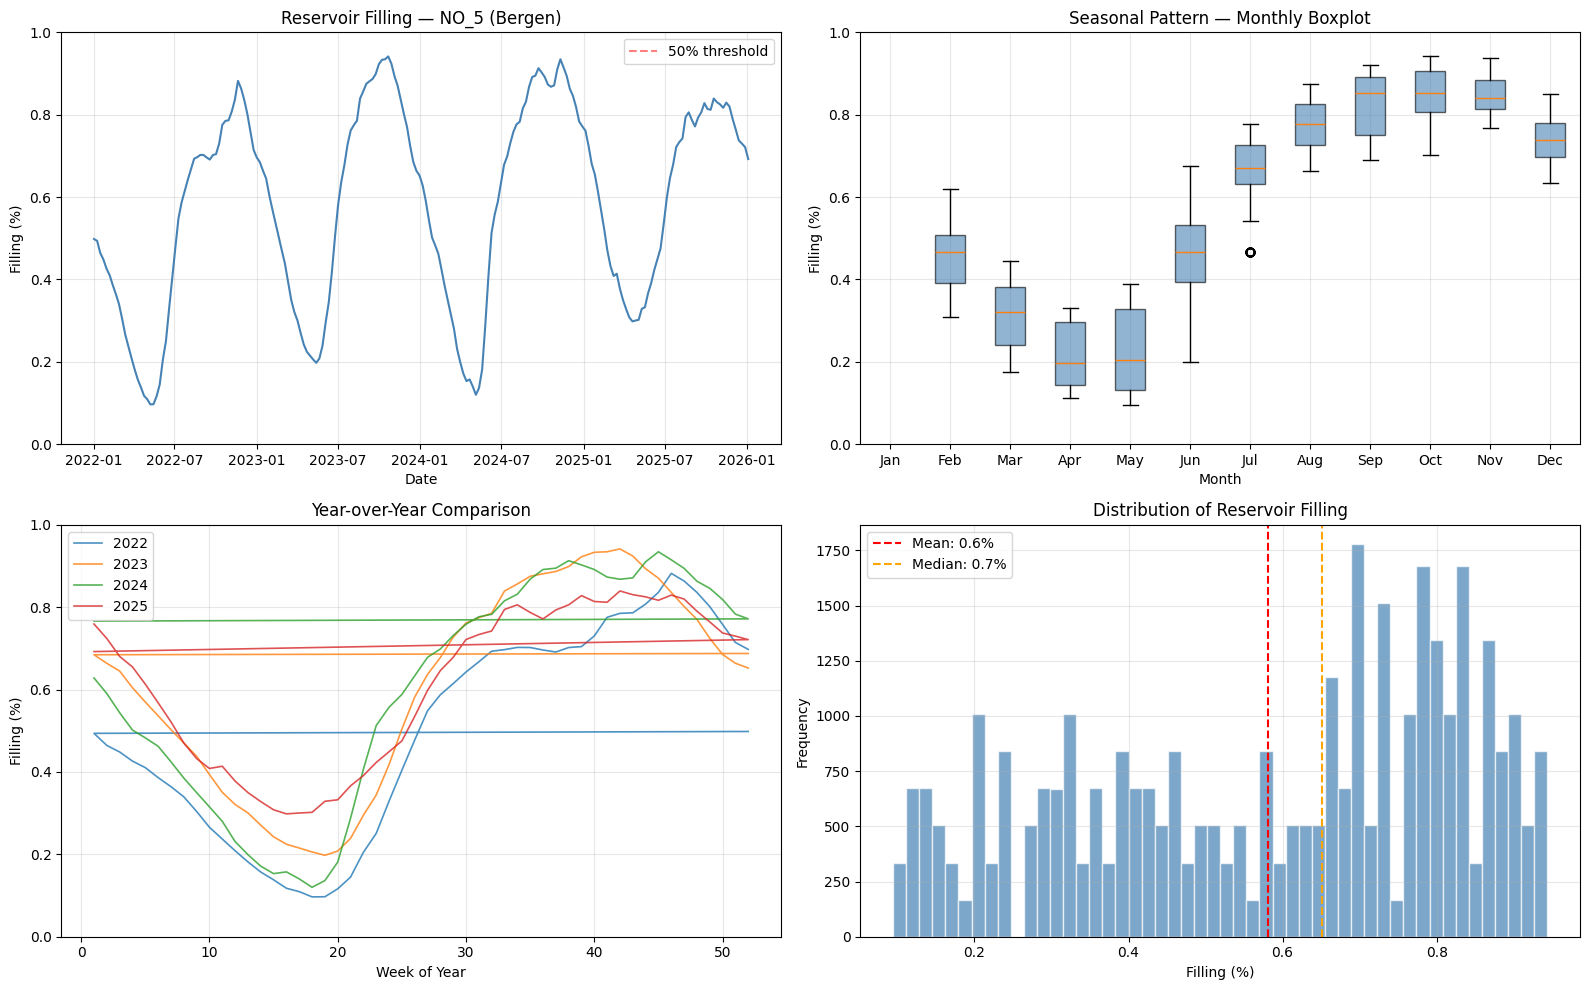


Descriptive Statistics for reservoir_filling_pct:
count    35041.00
mean         0.58
std          0.25
min          0.09
25%          0.37
50%          0.65
75%          0.79
max          0.94
Name: reservoir_filling_pct, dtype: float64

Skewness: -0.375
Kurtosis: -1.151


In [3]:
# EDA: Reservoir filling time series + seasonal patterns

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Panel 1: Full time series
ax = axes[0, 0]
# Resample to weekly for cleaner plotting (data is weekly anyway)
weekly = target.resample("W").mean()
ax.plot(weekly.index, weekly.values, color="steelblue", linewidth=1.5)
ax.set_xlabel("Date")
ax.set_ylabel("Filling (%)")
ax.set_title(f"Reservoir Filling — {ZONE} (Bergen)")
ax.set_ylim(0, 1)
ax.grid(True, alpha=0.3)
ax.axhline(50, color="red", linestyle="--", alpha=0.5, label="50% threshold")
ax.legend()

# Panel 2: Monthly boxplot (seasonal pattern)
ax = axes[0, 1]
monthly_data = [target[target.index.month == m].values for m in range(1, 13)]
bp = ax.boxplot(monthly_data, labels=["Jan", "Feb", "Mar", "Apr", "May", "Jun",
                                       "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"],
                patch_artist=True)
for patch in bp["boxes"]:
    patch.set_facecolor("steelblue")
    patch.set_alpha(0.6)
ax.set_xlabel("Month")
ax.set_ylabel("Filling (%)")
ax.set_title("Seasonal Pattern — Monthly Boxplot")
ax.set_ylim(0, 1)
ax.grid(True, alpha=0.3)

# Panel 3: Year-over-year comparison (by week of year)
ax = axes[1, 0]
colors_yr = ["tab:blue", "tab:orange", "tab:green", "tab:red"]
for i, year in enumerate(range(2022, 2026)):
    mask = target.index.year == year
    yearly = target[mask]
    weekly_yr = yearly.resample("W").mean()
    week_nums = weekly_yr.index.isocalendar().week.values
    ax.plot(week_nums, weekly_yr.values, color=colors_yr[i],
            linewidth=1.2, label=str(year), alpha=0.8)
ax.set_xlabel("Week of Year")
ax.set_ylabel("Filling (%)")
ax.set_title("Year-over-Year Comparison")
ax.set_ylim(0, 1)
ax.legend()
ax.grid(True, alpha=0.3)

# Panel 4: Distribution
ax = axes[1, 1]
ax.hist(target.dropna().values, bins=50, color="steelblue", alpha=0.7, edgecolor="white")
ax.axvline(target.mean(), color="red", linestyle="--", label=f"Mean: {target.mean():.1f}%")
ax.axvline(target.median(), color="orange", linestyle="--", label=f"Median: {target.median():.1f}%")
ax.set_xlabel("Filling (%)")
ax.set_ylabel("Frequency")
ax.set_title("Distribution of Reservoir Filling")
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Basic statistics
print(f"\nDescriptive Statistics for {TARGET_COL}:")
print(target.describe().round(2))
print(f"\nSkewness: {target.skew():.3f}")
print(f"Kurtosis: {target.kurtosis():.3f}")

Training:   26,304 hours  (2022-01-01 to 2024-12-31)
Validation:  4,343 hours  (2025-01-01 to 2025-06-30)
Test:        4,418 hours  (2025-07-01 to 2026-01-01)

Train mean: 0.6%, std: 0.3%
Val mean:   0.5%, std: 0.1%
Test mean:  0.8%, std: 0.1%


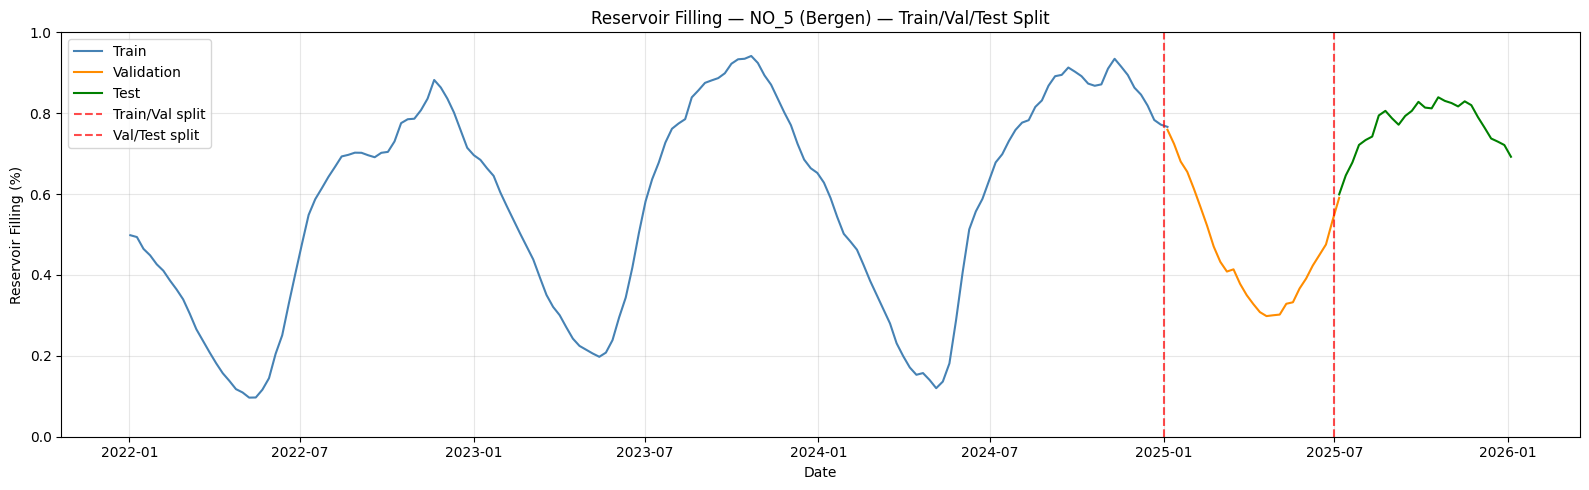

In [4]:
# Train / Validation / Test split
TRAIN_END = pd.Timestamp("2024-12-31 23:00", tz="Europe/Oslo")
VAL_END = pd.Timestamp("2025-06-30 23:00", tz="Europe/Oslo")

y_train = target[target.index <= TRAIN_END]
y_val = target[(target.index > TRAIN_END) & (target.index <= VAL_END)]
y_test = target[target.index > VAL_END]

# Also split the full DataFrame for features
df_train = df[df.index <= TRAIN_END]
df_val = df[(df.index > TRAIN_END) & (df.index <= VAL_END)]
df_test = df[df.index > VAL_END]

print(f"Training:   {len(y_train):>6,} hours  ({y_train.index.min().date()} to {y_train.index.max().date()})")
print(f"Validation: {len(y_val):>6,} hours  ({y_val.index.min().date()} to {y_val.index.max().date()})")
print(f"Test:       {len(y_test):>6,} hours  ({y_test.index.min().date()} to {y_test.index.max().date()})")
print(f"\nTrain mean: {y_train.mean():.1f}%, std: {y_train.std():.1f}%")
print(f"Val mean:   {y_val.mean():.1f}%, std: {y_val.std():.1f}%")
print(f"Test mean:  {y_test.mean():.1f}%, std: {y_test.std():.1f}%")

# Visualize the split
fig, ax = plt.subplots(figsize=(16, 5))
# Plot weekly resampled for clarity
ax.plot(y_train.resample("W").mean().index, y_train.resample("W").mean(),
        color="steelblue", linewidth=1.5, label="Train")
ax.plot(y_val.resample("W").mean().index, y_val.resample("W").mean(),
        color="darkorange", linewidth=1.5, label="Validation")
ax.plot(y_test.resample("W").mean().index, y_test.resample("W").mean(),
        color="green", linewidth=1.5, label="Test")
ax.axvline(TRAIN_END, color="red", linestyle="--", alpha=0.7, label="Train/Val split")
ax.axvline(VAL_END, color="red", linestyle="--", alpha=0.7, label="Val/Test split")
ax.set_xlabel("Date")
ax.set_ylabel("Reservoir Filling (%)")
ax.set_title(f"Reservoir Filling — {ZONE} (Bergen) — Train/Val/Test Split")
ax.set_ylim(0, 1)
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 2. Feature Preparation

**Leakage prevention is critical here.** The feature matrix contains several columns
that are derived directly from `reservoir_filling_pct`:

| Column | Why it leaks |
|--------|-------------|
| `reservoir_filling_twh` | Monotonic transform of filling % (TWh = % × capacity) |
| `reservoir_filling_change` | Week-over-week diff of the target |
| `reservoir_vs_median` | target minus 20-year median |
| `reservoir_vs_min` | target minus historical minimum |

These columns encode the answer in the features. If we leave them in,
the model will trivially achieve near-zero error by reading the target
through its derivatives.

`prepare_ml_features()` also drops NOK price columns and price lag columns
(standard behavior), which is fine — those are for the price forecasting task.

In [5]:
# Prepare features — drop leakage columns + standard NOK/price lag drops
X_train_full, y_train_full = prepare_ml_features(
    df_train,
    target_col=TARGET_COL,
    drop_cols=LEAKAGE_COLS,
)
X_val_full, y_val_full = prepare_ml_features(
    df_val,
    target_col=TARGET_COL,
    drop_cols=LEAKAGE_COLS,
)

print(f"Feature matrix: {X_train_full.shape[1]} features")
print(f"Training:   {len(X_train_full):,} samples")
print(f"Validation: {len(X_val_full):,} samples")

# Verify leakage columns are gone
remaining_reservoir = [c for c in X_train_full.columns if "reservoir" in c]
print(f"\nRemaining reservoir columns (should be empty): {remaining_reservoir}")
leakage_remaining = [c for c in LEAKAGE_COLS if c in X_train_full.columns]
if leakage_remaining:
    print(f"WARNING: Leakage columns still present: {leakage_remaining}")
else:
    print("Leakage columns successfully removed.")

# Group features by category
categories = {
    "Calendar": [c for c in X_train_full.columns if c in [
        "hour_of_day", "day_of_week", "month", "week_of_year",
        "is_weekend", "is_holiday", "is_business_hour"]],
    "Weather": [c for c in X_train_full.columns if c in [
        "temperature", "wind_speed", "precipitation",
        "temperature_lag_24h", "temperature_rolling_24h_mean"]],
    "Commodities": [c for c in X_train_full.columns if any(
        c.startswith(p) for p in ["ttf_", "brent_", "coal_", "ng_"])],
    "Price (EUR)": [c for c in X_train_full.columns if c.startswith("price_eur")],
    "FX": [c for c in X_train_full.columns if c == "eur_nok"],
    "ENTSO-E": [c for c in X_train_full.columns if any(
        c.startswith(p) for p in ["actual_", "load_", "generation_",
                                   "hydro_", "wind_share", "total_net",
                                   "n_cables"])],
    "Internal Flows": [c for c in X_train_full.columns if any(
        c.startswith(p) for p in ["flow_from_", "total_internal_",
                                   "net_internal_"])],
    "Statnett": [c for c in X_train_full.columns if any(
        c.startswith(p) for p in ["net_exchange", "production_", "consumption_", "net_balance"])],
}

all_categorized = set()
for cols in categories.values():
    all_categorized.update(cols)
uncategorized = [c for c in X_train_full.columns if c not in all_categorized]
if uncategorized:
    categories["Other"] = uncategorized

print("\nFeatures by category:")
for cat, cols in categories.items():
    if cols:
        print(f"  {cat} ({len(cols)}): {', '.join(cols[:5])}{'...' if len(cols) > 5 else ''}")

2026-02-24 22:39:56,671 src.models.train INFO Dropped 18 NOK columns (redundant with EUR)
2026-02-24 22:39:56,673 src.models.train INFO Dropped 8 price lag columns (learning fundamentals, not shortcuts): ['price_lag_1h', 'price_lag_24h', 'price_lag_168h', 'price_rolling_24h_mean', 'price_rolling_24h_std', 'price_rolling_168h_mean', 'price_diff_24h', 'price_diff_168h']
2026-02-24 22:39:56,674 src.models.train INFO Dropped 24 rows with NaN target
2026-02-24 22:39:56,675 src.models.train INFO Prepared 26280 samples with 32 features (target: reservoir_filling_pct)
2026-02-24 22:39:56,677 src.models.train INFO Dropped 18 NOK columns (redundant with EUR)
2026-02-24 22:39:56,678 src.models.train INFO Dropped 8 price lag columns (learning fundamentals, not shortcuts): ['price_lag_1h', 'price_lag_24h', 'price_lag_168h', 'price_rolling_24h_mean', 'price_rolling_24h_std', 'price_rolling_168h_mean', 'price_diff_24h', 'price_diff_168h']
2026-02-24 22:39:56,679 src.models.train INFO Prepared 4343 sa

Feature matrix: 32 features
Training:   26,280 samples
Validation: 4,343 samples

Remaining reservoir columns (should be empty): []
Leakage columns successfully removed.

Features by category:
  Calendar (7): hour_of_day, day_of_week, month, week_of_year, is_weekend...
  Weather (5): temperature, wind_speed, precipitation, temperature_lag_24h, temperature_rolling_24h_mean
  Commodities (5): ttf_gas_close, brent_oil_close, coal_close, ng_fut_close, ttf_gas_change_7d
  Price (EUR) (1): price_eur_mwh
  FX (1): eur_nok
  ENTSO-E (9): actual_load, load_lag_24h, load_lag_168h, load_rolling_24h_mean, generation_hydro...
  Statnett (4): net_exchange_mwh, production_mwh, consumption_mwh, net_balance_mwh


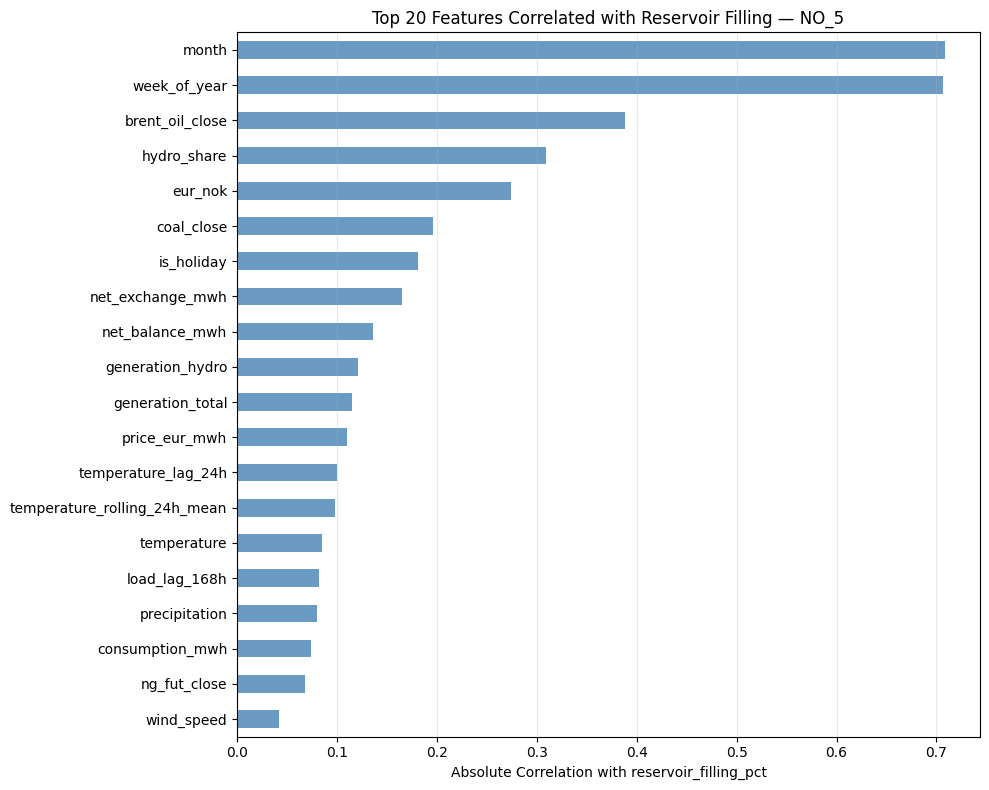

Top 10 correlated features:
  month: 0.708
  week_of_year: 0.706
  brent_oil_close: 0.389
  hydro_share: 0.309
  eur_nok: 0.275
  coal_close: 0.196
  is_holiday: 0.181
  net_exchange_mwh: 0.165
  net_balance_mwh: 0.136
  generation_hydro: 0.121

Note: High correlation with seasonal features (month, week_of_year) is expected
because reservoir filling follows a strong annual cycle (fills in spring/summer,
depletes in autumn/winter).


In [6]:
# Correlation with target — top 20 features
corr_with_target = X_train_full.corrwith(y_train_full).abs().sort_values(ascending=False)
top_corr = corr_with_target.head(20)

fig, ax = plt.subplots(figsize=(10, 8))
top_corr.plot(kind="barh", ax=ax, color="steelblue", alpha=0.8)
ax.set_xlabel(f"Absolute Correlation with {TARGET_COL}")
ax.set_title(f"Top 20 Features Correlated with Reservoir Filling — {ZONE}")
ax.invert_yaxis()
ax.grid(True, alpha=0.3, axis="x")
plt.tight_layout()
plt.show()

print("Top 10 correlated features:")
for feat, corr in top_corr.head(10).items():
    print(f"  {feat}: {corr:.3f}")

print(f"\nNote: High correlation with seasonal features (month, week_of_year) is expected")
print(f"because reservoir filling follows a strong annual cycle (fills in spring/summer,")
print(f"depletes in autumn/winter).")

## 3. Naive Baseline

The simplest forecast for reservoir filling: **same week last year**.

Reservoir filling follows a strong annual cycle — spring snowmelt fills the reservoirs,
winter consumption depletes them. Using `lag=52*168` (52 weeks in hourly resolution)
gives us the same week from the previous year as our prediction.

This captures the seasonal pattern perfectly but misses year-to-year variations
(e.g., unusually dry summers or cold winters).

2026-02-24 22:39:56,789 src.models.forecasters INFO Naive (same week last year) fit complete: 26304 samples in 0.0 seconds


Naive Baseline Results (same week last year):
  mae: 0.124
  rmse: 0.13
  mape: 30.38
  directional_accuracy: 0.5
  peak_hour_mae: 0.124


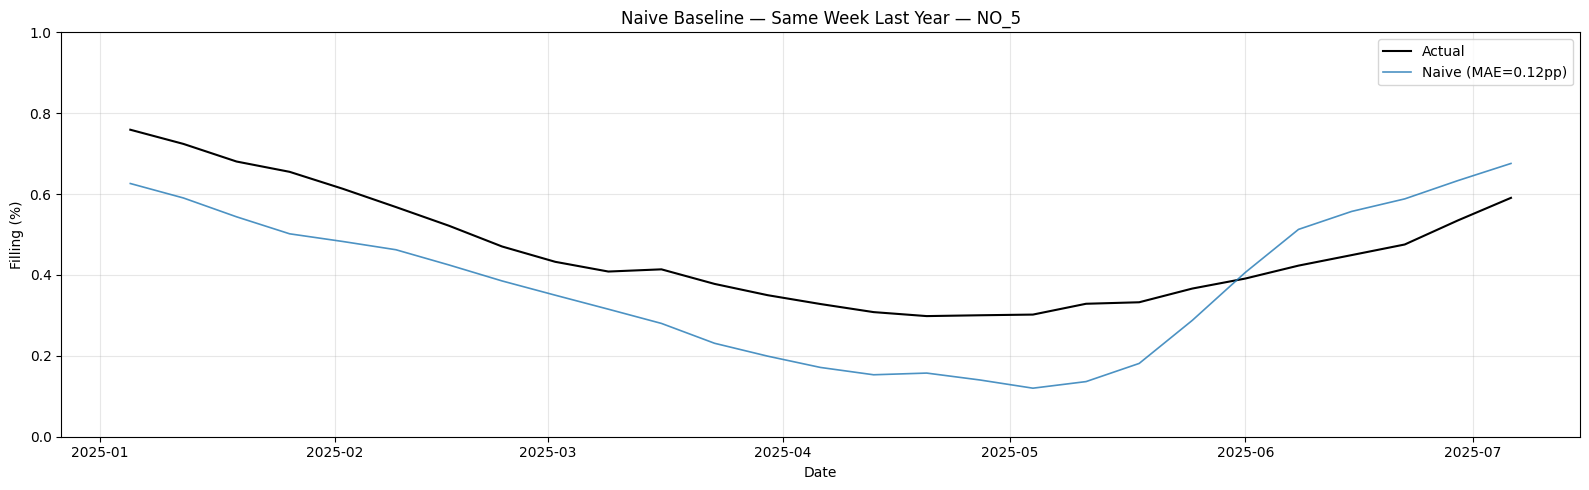

In [7]:
# Collect results for all methods
all_results = []
all_forecasts = {}

# Naive baseline: same week last year (52 weeks * 168 hours/week = 8736 hours)
NAIVE_LAG = 52 * 168  # 1 year in hours
naive = NaiveForecaster(
    name="Naive (same week last year)",
    horizon=len(y_val),
    frequency="h",
    lag=NAIVE_LAG,
)
naive.fit(y_train)
naive_pred = naive.predict(steps=len(y_val))
naive_pred.index = y_val.index

naive_metrics = compute_metrics(y_val, naive_pred)
all_results.append({
    "name": "Naive (same week last year)",
    "metrics": naive_metrics,
    "fit_time": naive.fit_time_seconds,
})
all_forecasts["Naive"] = naive_pred

print("Naive Baseline Results (same week last year):")
for k, v in naive_metrics.items():
    print(f"  {k}: {v}")

# Visualize naive vs actual
fig, ax = plt.subplots(figsize=(16, 5))
# Resample to weekly for clarity
ax.plot(y_val.resample("W").mean().index, y_val.resample("W").mean(),
        color="black", linewidth=1.5, label="Actual")
ax.plot(naive_pred.resample("W").mean().index, naive_pred.resample("W").mean(),
        color="tab:blue", linewidth=1.2, alpha=0.8,
        label=f"Naive (MAE={naive_metrics['mae']:.2f}pp)")
ax.set_xlabel("Date")
ax.set_ylabel("Filling (%)")
ax.set_title(f"Naive Baseline — Same Week Last Year — {ZONE}")
ax.set_ylim(0, 1)
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 4. ML Models

We train XGBoost, LightGBM, and CatBoost on the fundamental feature set.
The target is `reservoir_filling_pct` (0–100%), so metrics are in percentage points.

**Expected drivers** (from domain knowledge):
- **Season** (month, week_of_year) — strongest driver, annual filling cycle
- **Temperature** — cold weather increases heating demand, depleting reservoirs
- **Precipitation** — rain and snowmelt fill reservoirs
- **Production/consumption** — high hydro production depletes reservoirs
- **Price** — high prices incentivize more production (faster depletion)

In [8]:
%%time

# Train XGBoost
xgb_model = MLPriceForecaster("xgboost")
xgb_model.fit(X_train_full, y_train_full, X_val_full, y_val_full)
xgb_pred = xgb_model.predict(X_val_full)

xgb_metrics = compute_metrics(y_val_full, xgb_pred, naive_pred=naive_pred)
all_results.append({"name": "XGBoost", "metrics": xgb_metrics, "fit_time": xgb_model.fit_time_seconds})
all_forecasts["XGBoost"] = xgb_pred

print(f"XGBoost Results:")
for k, v in xgb_metrics.items():
    print(f"  {k}: {v}")
print(f"\n  Fit time: {xgb_model.fit_time_seconds:.1f}s")
print(f"  vs Naive: {'BETTER' if xgb_metrics['mae'] < naive_metrics['mae'] else 'WORSE'} "
      f"(skill_score: {xgb_metrics.get('skill_score', 'N/A')})")

2026-02-24 22:39:57,294 src.models.train INFO xgboost fit: 26280 samples, 32 features in 0.2 s, best_iteration=28


XGBoost Results:
  mae: 0.032
  rmse: 0.045
  mape: 6.38
  directional_accuracy: 0.4
  peak_hour_mae: 0.032
  skill_score: 0.738

  Fit time: 0.2s
  vs Naive: BETTER (skill_score: 0.738)
CPU times: user 591 ms, sys: 295 ms, total: 886 ms
Wall time: 430 ms


In [9]:
%%time

# Train LightGBM
lgbm_model = MLPriceForecaster("lightgbm")
lgbm_model.fit(X_train_full, y_train_full, X_val_full, y_val_full)
lgbm_pred = lgbm_model.predict(X_val_full)

lgbm_metrics = compute_metrics(y_val_full, lgbm_pred, naive_pred=naive_pred)
all_results.append({"name": "LightGBM", "metrics": lgbm_metrics, "fit_time": lgbm_model.fit_time_seconds})
all_forecasts["LightGBM"] = lgbm_pred

print(f"LightGBM Results:")
for k, v in lgbm_metrics.items():
    print(f"  {k}: {v}")
print(f"\n  Fit time: {lgbm_model.fit_time_seconds:.1f}s")
print(f"  vs XGBoost: {'BETTER' if lgbm_metrics['mae'] < xgb_metrics['mae'] else 'WORSE or EQUAL'} "
      f"({lgbm_model.fit_time_seconds:.1f}s vs {xgb_model.fit_time_seconds:.1f}s)")

2026-02-24 22:39:58,150 src.models.train INFO lightgbm fit: 26280 samples, 32 features in 0.8 s, best_iteration=24


LightGBM Results:
  mae: 0.033
  rmse: 0.046
  mape: 6.52
  directional_accuracy: 0.3
  peak_hour_mae: 0.033
  skill_score: 0.734

  Fit time: 0.8s
  vs XGBoost: WORSE or EQUAL (0.8s vs 0.2s)
CPU times: user 752 ms, sys: 1.81 s, total: 2.56 s
Wall time: 853 ms


In [10]:
%%time

# Train CatBoost
cat_model = MLPriceForecaster("catboost")
cat_model.fit(X_train_full, y_train_full, X_val_full, y_val_full)
cat_pred = cat_model.predict(X_val_full)

cat_metrics = compute_metrics(y_val_full, cat_pred, naive_pred=naive_pred)
all_results.append({"name": "CatBoost", "metrics": cat_metrics, "fit_time": cat_model.fit_time_seconds})
all_forecasts["CatBoost"] = cat_pred

print(f"CatBoost Results:")
for k, v in cat_metrics.items():
    print(f"  {k}: {v}")
print(f"\n  Fit time: {cat_model.fit_time_seconds:.1f}s")

# Quick comparison
print(f"\nML model comparison (MAE in percentage points):")
print(f"  XGBoost:  {xgb_metrics['mae']:.3f} pp")
print(f"  LightGBM: {lgbm_metrics['mae']:.3f} pp")
print(f"  CatBoost: {cat_metrics['mae']:.3f} pp")
print(f"  Naive:    {naive_metrics['mae']:.3f} pp")

2026-02-24 22:39:58,445 src.models.train INFO catboost fit: 26280 samples, 32 features in 0.3 s, best_iteration=38


CatBoost Results:
  mae: 0.049
  rmse: 0.069
  mape: 9.34
  directional_accuracy: 0.1
  peak_hour_mae: 0.049
  skill_score: 0.603

  Fit time: 0.3s

ML model comparison (MAE in percentage points):
  XGBoost:  0.032 pp
  LightGBM: 0.033 pp
  CatBoost: 0.049 pp
  Naive:    0.124 pp
CPU times: user 1.37 s, sys: 245 ms, total: 1.61 s
Wall time: 286 ms


In [11]:
# Build ensemble (inverse-MAE weighted)
model_maes = {
    "xgboost": xgb_metrics["mae"],
    "lightgbm": lgbm_metrics["mae"],
    "catboost": cat_metrics["mae"],
}
inv_maes = {k: 1.0 / v for k, v in model_maes.items()}
total_inv = sum(inv_maes.values())
weights = {k: v / total_inv for k, v in inv_maes.items()}

print("Ensemble weights (inverse-MAE):")
for k, w in weights.items():
    print(f"  {k}: {w:.3f} (MAE: {model_maes[k]:.3f} pp)")

# Weighted ensemble
ensemble_pred = (
    weights["xgboost"] * xgb_pred
    + weights["lightgbm"] * lgbm_pred
    + weights["catboost"] * cat_pred
)
ensemble_pred.name = "Ensemble (weighted)"

# Simple average
simple_avg_pred = (xgb_pred + lgbm_pred + cat_pred) / 3
simple_avg_pred.name = "Ensemble (simple avg)"

# Evaluate both
ens_w_metrics = compute_metrics(y_val_full, ensemble_pred, naive_pred=naive_pred)
ens_s_metrics = compute_metrics(y_val_full, simple_avg_pred, naive_pred=naive_pred)

all_results.append({"name": "Ensemble (weighted)", "metrics": ens_w_metrics, "fit_time": 0})
all_results.append({"name": "Ensemble (simple avg)", "metrics": ens_s_metrics, "fit_time": 0})
all_forecasts["Ensemble (weighted)"] = ensemble_pred
all_forecasts["Ensemble (simple avg)"] = simple_avg_pred

print(f"\nEnsemble Results:")
print(f"  Weighted:   MAE={ens_w_metrics['mae']:.3f} pp, skill_score={ens_w_metrics.get('skill_score', 'N/A')}")
print(f"  Simple avg: MAE={ens_s_metrics['mae']:.3f} pp, skill_score={ens_s_metrics.get('skill_score', 'N/A')}")
print(f"  Best individual: {min(model_maes, key=model_maes.get)} MAE={min(model_maes.values()):.3f} pp")
print(f"\n  Ensemble {'beats' if ens_w_metrics['mae'] <= min(model_maes.values()) else 'does not beat'} best individual model")

Ensemble weights (inverse-MAE):
  xgboost: 0.381 (MAE: 0.032 pp)
  lightgbm: 0.370 (MAE: 0.033 pp)
  catboost: 0.249 (MAE: 0.049 pp)

Ensemble Results:
  Weighted:   MAE=0.035 pp, skill_score=0.716
  Simple avg: MAE=0.036 pp, skill_score=0.706
  Best individual: xgboost MAE=0.032 pp

  Ensemble does not beat best individual model


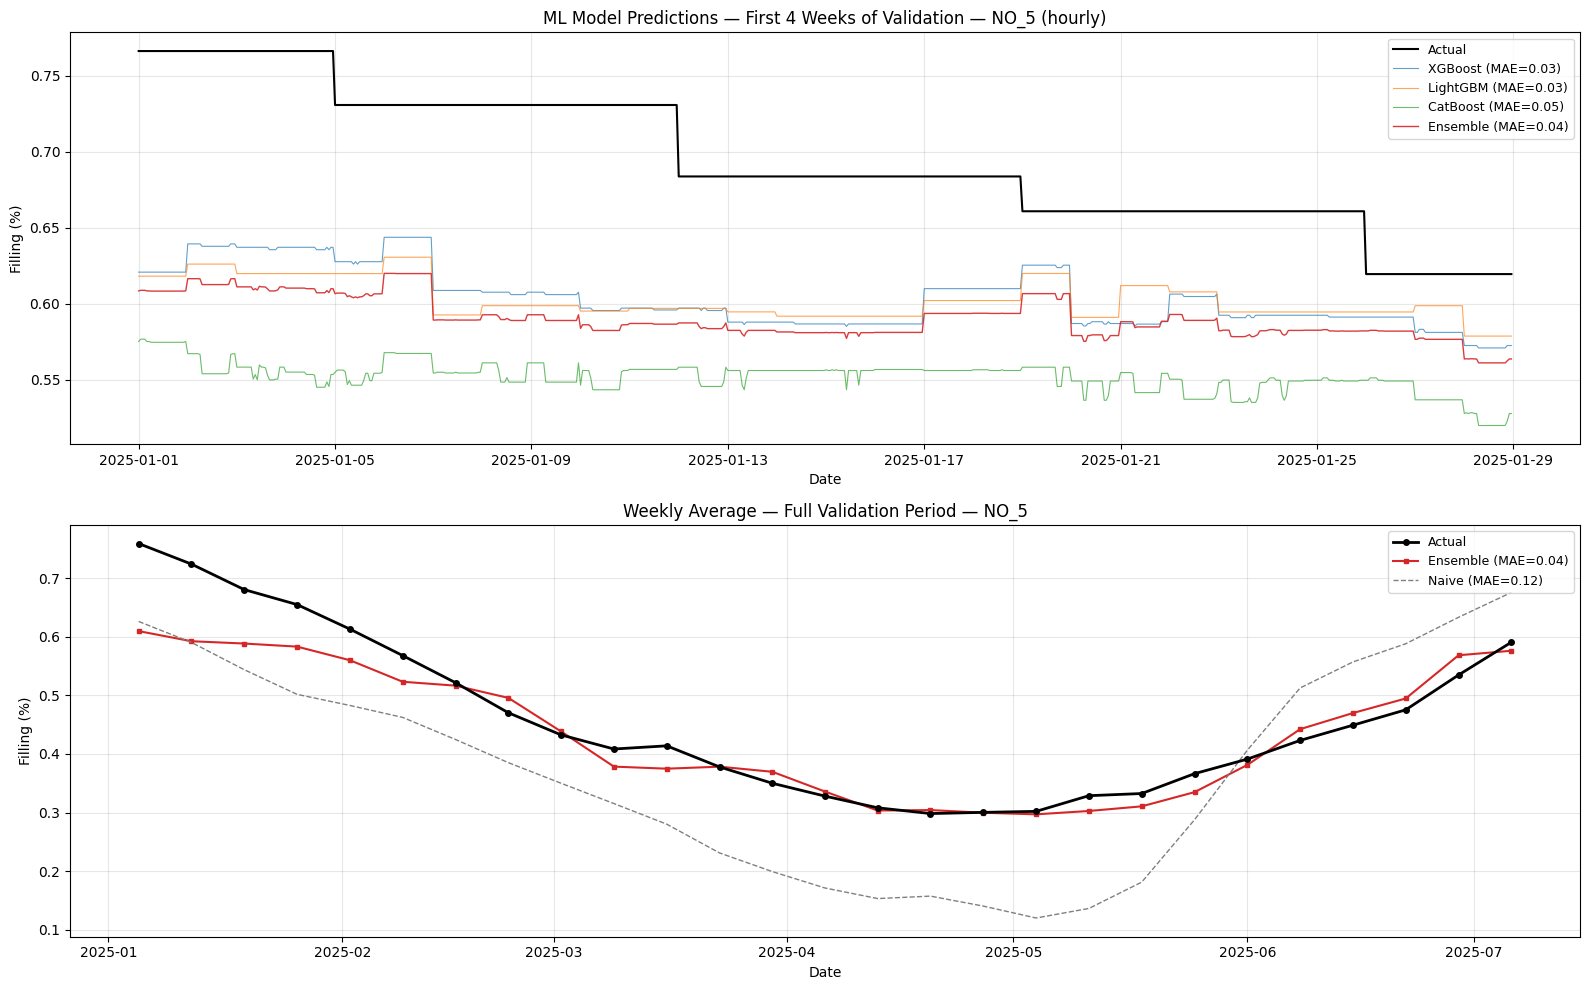

In [12]:
# Forecast overlay — first 4 weeks of validation
# Reservoir changes slowly (weekly), so 4 weeks gives a clearer picture than 2
four_weeks = y_val_full.index[:4 * 168]

fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Panel 1: Hourly view (first 4 weeks)
ax = axes[0]
ax.plot(y_val_full.loc[four_weeks].index, y_val_full.loc[four_weeks],
        color="black", linewidth=1.5, label="Actual", zorder=5)
ax.plot(xgb_pred.loc[four_weeks].index, xgb_pred.loc[four_weeks],
        color="tab:blue", linewidth=0.8, alpha=0.7, label=f"XGBoost (MAE={xgb_metrics['mae']:.2f})")
ax.plot(lgbm_pred.loc[four_weeks].index, lgbm_pred.loc[four_weeks],
        color="tab:orange", linewidth=0.8, alpha=0.7, label=f"LightGBM (MAE={lgbm_metrics['mae']:.2f})")
ax.plot(cat_pred.loc[four_weeks].index, cat_pred.loc[four_weeks],
        color="tab:green", linewidth=0.8, alpha=0.7, label=f"CatBoost (MAE={cat_metrics['mae']:.2f})")
ax.plot(ensemble_pred.loc[four_weeks].index, ensemble_pred.loc[four_weeks],
        color="tab:red", linewidth=1.0, alpha=0.9, label=f"Ensemble (MAE={ens_w_metrics['mae']:.2f})")
ax.set_xlabel("Date")
ax.set_ylabel("Filling (%)")
ax.set_title(f"ML Model Predictions — First 4 Weeks of Validation — {ZONE} (hourly)")
ax.legend(loc="upper right", fontsize=9)
ax.grid(True, alpha=0.3)

# Panel 2: Weekly resampled (full validation)
ax = axes[1]
ax.plot(y_val_full.resample("W").mean().index, y_val_full.resample("W").mean(),
        color="black", linewidth=2, marker="o", markersize=4, label="Actual", zorder=5)
ax.plot(ensemble_pred.resample("W").mean().index, ensemble_pred.resample("W").mean(),
        color="tab:red", linewidth=1.5, marker="s", markersize=3,
        label=f"Ensemble (MAE={ens_w_metrics['mae']:.2f})")
ax.plot(naive_pred.resample("W").mean().index, naive_pred.resample("W").mean(),
        color="gray", linewidth=1, linestyle="--",
        label=f"Naive (MAE={naive_metrics['mae']:.2f})")
ax.set_xlabel("Date")
ax.set_ylabel("Filling (%)")
ax.set_title(f"Weekly Average — Full Validation Period — {ZONE}")
ax.legend(loc="upper right", fontsize=9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Walk-Forward Validation

Walk-forward validation simulates real deployment — the model always predicts
unseen future data with an expanding training window.

```
Fold 1: Train [2022-01 → 2025-01] | Val [2025-01 → 2025-02]
Fold 2: Train [2022-01 → 2025-02] | Val [2025-02 → 2025-03]
...
```

For reservoir filling this is especially important because the seasonal pattern
means performance may vary strongly by month (filling phase vs depletion phase).

2026-02-24 22:39:58,641 src.models.train INFO Dropped 18 NOK columns (redundant with EUR)
2026-02-24 22:39:58,642 src.models.train INFO Dropped 8 price lag columns (learning fundamentals, not shortcuts): ['price_lag_1h', 'price_lag_24h', 'price_lag_168h', 'price_rolling_24h_mean', 'price_rolling_24h_std', 'price_rolling_168h_mean', 'price_diff_24h', 'price_diff_168h']
2026-02-24 22:39:58,643 src.models.train INFO Dropped 24 rows with NaN target
2026-02-24 22:39:58,645 src.models.train INFO Prepared 30623 samples with 36 features (target: reservoir_filling_pct)


Walk-forward validation using: xgboost
Data: 30,647 hours
Configuration: 6 folds, ~720 hours (~1 month) each



2026-02-24 22:39:59,180 src.models.train INFO xgboost fit: 26303 samples, 36 features in 0.5 s, best_iteration=204
2026-02-24 22:39:59,185 src.models.train INFO Fold 1/6: train=26303, val=720, MAE=0.01, fit=0.5s
2026-02-24 22:39:59,465 src.models.train INFO xgboost fit: 27023 samples, 36 features in 0.3 s, best_iteration=59
2026-02-24 22:39:59,470 src.models.train INFO Fold 2/6: train=27023, val=720, MAE=0.01, fit=0.3s
2026-02-24 22:40:00,044 src.models.train INFO xgboost fit: 27743 samples, 36 features in 0.6 s, best_iteration=219
2026-02-24 22:40:00,049 src.models.train INFO Fold 3/6: train=27743, val=720, MAE=0.01, fit=0.6s
2026-02-24 22:40:00,598 src.models.train INFO xgboost fit: 28463 samples, 36 features in 0.5 s, best_iteration=202
2026-02-24 22:40:00,603 src.models.train INFO Fold 4/6: train=28463, val=720, MAE=0.01, fit=0.5s
2026-02-24 22:40:01,078 src.models.train INFO xgboost fit: 29183 samples, 36 features in 0.5 s, best_iteration=147
2026-02-24 22:40:01,083 src.models.tra

,Fold,Train Size,Val Period,MAE (pp),RMSE (pp),Skill Score,Dir. Acc.,Fit Time (s)
0,1,"26,303",2025-01-01 -> 2025-01-31,0.012,0.015,0.646,0.6,0.53
1,2,"27,023",2025-01-31 -> 2025-03-02,0.010,0.012,0.784,0.7,0.28
2,3,"27,743",2025-03-02 -> 2025-04-01,0.005,0.006,0.821,0.6,0.57
3,4,"28,463",2025-04-02 -> 2025-05-01,0.007,0.007,0.453,0.4,0.54
4,5,"29,183",2025-05-02 -> 2025-05-31,0.018,0.025,0.166,0.6,0.47
5,6,"29,903",2025-06-01 -> 2025-06-30,0.018,0.021,0.503,0.4,0.53



Walk-forward MAE summary:
  Mean: 0.012 pp
  Std:  0.005 pp
  Min:  0.005 (best fold)
  Max:  0.018 (worst fold)


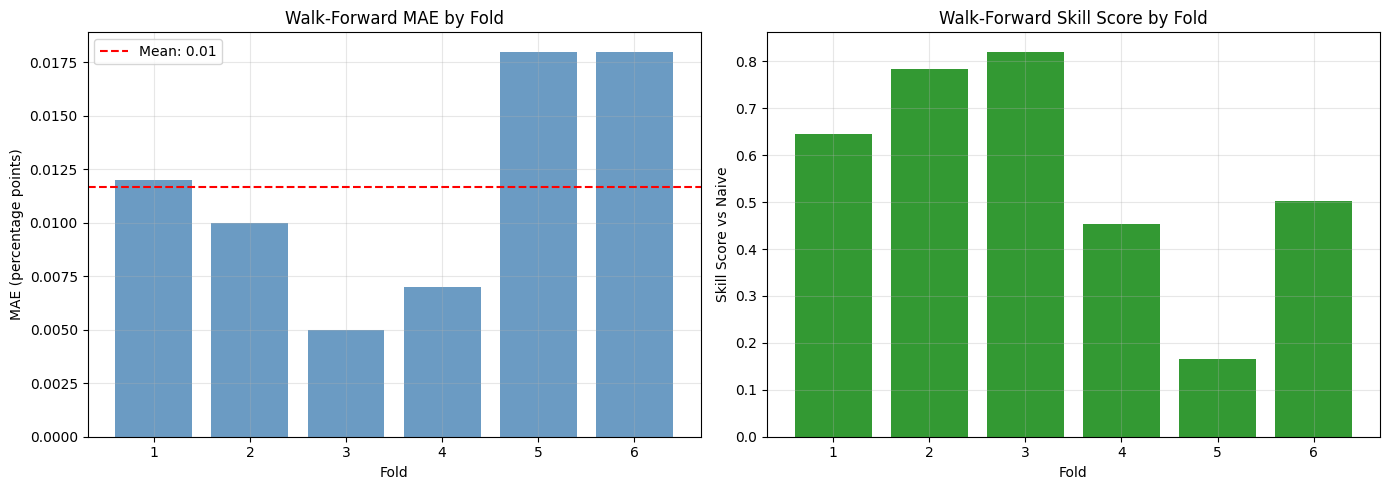

CPU times: user 6.13 s, sys: 4.05 s, total: 10.2 s
Wall time: 3.09 s


In [13]:
%%time

# Walk-forward validation with expanding window
df_walkforward = pd.concat([df_train, df_val])

# Use the best-performing individual model type
best_model_type = min(model_maes, key=model_maes.get)
print(f"Walk-forward validation using: {best_model_type}")
print(f"Data: {len(df_walkforward):,} hours")
print(f"Configuration: 6 folds, ~720 hours (~1 month) each\n")

wf_results = walk_forward_validate(
    df_walkforward,
    model_type=best_model_type,
    n_splits=6,
    val_size_hours=720,
    target_col=TARGET_COL,
)

# Display per-fold metrics
wf_rows = []
for r in wf_results:
    row = {
        "Fold": r["fold"],
        "Train Size": f"{r['train_size']:,}",
        "Val Period": f"{r['val_start'].strftime('%Y-%m-%d')} -> {r['val_end'].strftime('%Y-%m-%d')}",
        "MAE (pp)": r["metrics"].get("mae", np.nan),
        "RMSE (pp)": r["metrics"].get("rmse", np.nan),
        "Skill Score": r["metrics"].get("skill_score", np.nan),
        "Dir. Acc.": r["metrics"].get("directional_accuracy", np.nan),
        "Fit Time (s)": r["fit_time"],
    }
    wf_rows.append(row)

wf_df = pd.DataFrame(wf_rows)
display(wf_df)

# Summary statistics
mae_values = [r["metrics"]["mae"] for r in wf_results if "mae" in r["metrics"]]
print(f"\nWalk-forward MAE summary:")
print(f"  Mean: {np.mean(mae_values):.3f} pp")
print(f"  Std:  {np.std(mae_values):.3f} pp")
print(f"  Min:  {np.min(mae_values):.3f} (best fold)")
print(f"  Max:  {np.max(mae_values):.3f} (worst fold)")

# Walk-forward stability plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# MAE per fold
ax = axes[0]
folds = [r["fold"] for r in wf_results]
maes = [r["metrics"]["mae"] for r in wf_results]
skills = [r["metrics"].get("skill_score", 0) for r in wf_results]

ax.bar(folds, maes, color="steelblue", alpha=0.8)
ax.axhline(np.mean(maes), color="red", linestyle="--", label=f"Mean: {np.mean(maes):.2f}")
ax.set_xlabel("Fold")
ax.set_ylabel("MAE (percentage points)")
ax.set_title("Walk-Forward MAE by Fold")
ax.legend()
ax.grid(True, alpha=0.3)

# Skill score per fold
ax = axes[1]
colors = ["green" if s > 0 else "red" for s in skills]
ax.bar(folds, skills, color=colors, alpha=0.8)
ax.axhline(0, color="black", linestyle="-", linewidth=0.5)
ax.set_xlabel("Fold")
ax.set_ylabel("Skill Score vs Naive")
ax.set_title("Walk-Forward Skill Score by Fold")
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. SHAP Analysis

SHAP reveals which features drive reservoir filling predictions:

- **Temperature, precipitation** — weather directly affects inflow and outflow
- **Month, week_of_year** — strong seasonal cycle in filling
- **Production/consumption** — hydro production depletes reservoirs
- **Price** — high prices incentivize more production

Unlike price forecasting where gas price dominates, reservoir forecasting
should be dominated by weather and seasonal features — the physical inputs
and outputs of the hydro system.

Computing SHAP values for XGBoost model...
Using 4343 validation samples

SHAP values computed: (2000, 32)
Base value (expected prediction): 0.57%


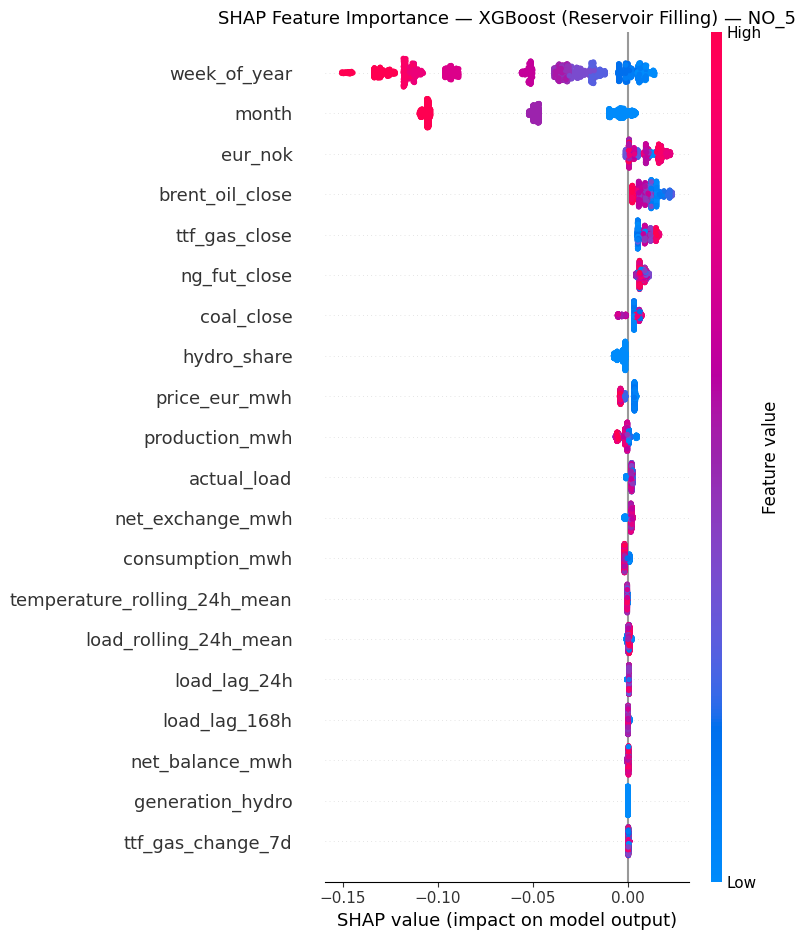


Top 10 features by mean |SHAP value|:
  1. week_of_year: 0.0550 pp
  2. month: 0.0489 pp
  3. eur_nok: 0.0103 pp
  4. brent_oil_close: 0.0095 pp
  5. ttf_gas_close: 0.0092 pp
  6. ng_fut_close: 0.0074 pp
  7. coal_close: 0.0047 pp
  8. hydro_share: 0.0039 pp
  9. price_eur_mwh: 0.0033 pp
  10. production_mwh: 0.0024 pp


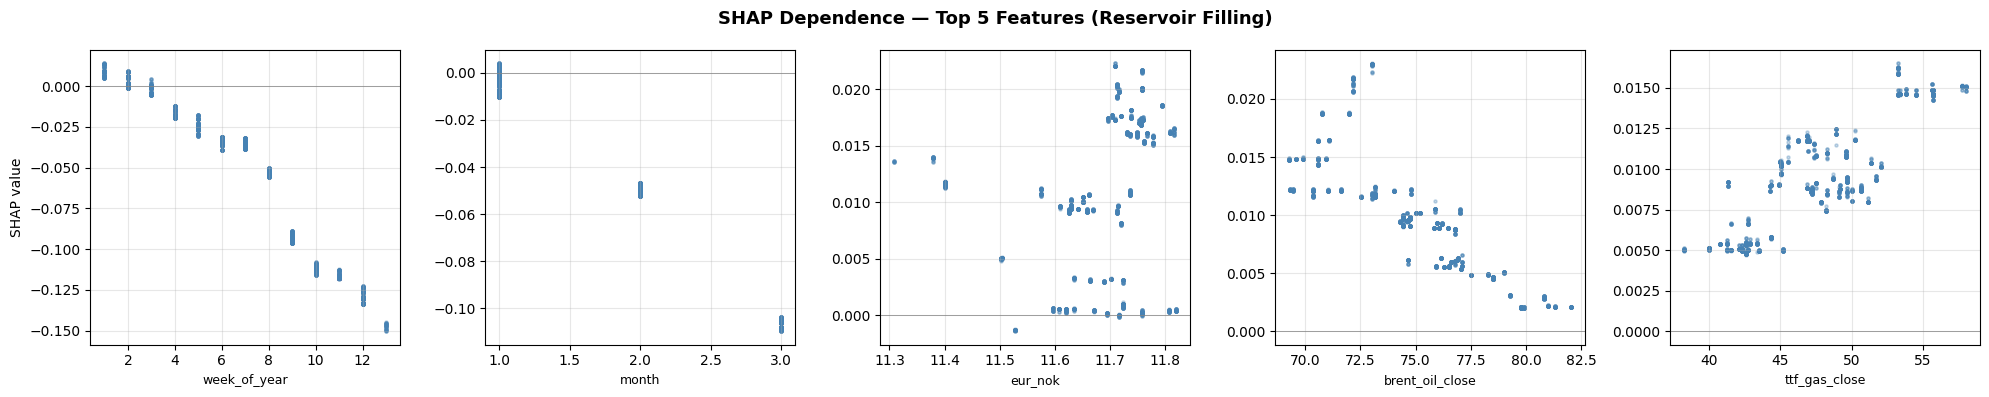

CPU times: user 1.22 s, sys: 128 ms, total: 1.35 s
Wall time: 1.25 s


In [14]:
%%time

import shap

# Use XGBoost for SHAP (best native support)
print("Computing SHAP values for XGBoost model...")
print(f"Using {len(X_val_full)} validation samples\n")

# Subsample for speed
shap_sample_size = min(2000, len(X_val_full))
X_shap = X_val_full.ffill().bfill().fillna(0).iloc[:shap_sample_size]

explainer = shap.TreeExplainer(xgb_model.model_)
shap_values = explainer.shap_values(X_shap)

print(f"SHAP values computed: {shap_values.shape}")
print(f"Base value (expected prediction): {explainer.expected_value:.2f}%")

# SHAP summary plot
plt.figure(figsize=(10, 10))
shap.summary_plot(shap_values, X_shap, max_display=20, show=False)
plt.title(f"SHAP Feature Importance — XGBoost (Reservoir Filling) — {ZONE}", fontsize=13)
plt.tight_layout()
plt.show()

# Mean absolute SHAP values (global importance)
mean_abs_shap = pd.Series(
    np.abs(shap_values).mean(axis=0),
    index=X_shap.columns,
).sort_values(ascending=False)

print("\nTop 10 features by mean |SHAP value|:")
for i, (feat, val) in enumerate(mean_abs_shap.head(10).items(), 1):
    print(f"  {i}. {feat}: {val:.4f} pp")

# SHAP dependence plots for top 5 features
top_5_features = mean_abs_shap.head(5).index.tolist()

fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for i, feat in enumerate(top_5_features):
    ax = axes[i]
    feat_idx = list(X_shap.columns).index(feat)
    ax.scatter(X_shap[feat].values, shap_values[:, feat_idx],
               alpha=0.3, s=5, color="steelblue")
    ax.set_xlabel(feat, fontsize=9)
    ax.set_ylabel("SHAP value" if i == 0 else "")
    ax.axhline(0, color="gray", linewidth=0.5)
    ax.grid(True, alpha=0.3)

fig.suptitle("SHAP Dependence — Top 5 Features (Reservoir Filling)", fontsize=13, fontweight="bold")
plt.tight_layout()
plt.show()

## 7. Forward Forecast

Use the Yr weather forecast to predict reservoir filling for the next ~9 days.

Since `forecast_with_yr()` is price-specific (returns EUR/MWh and NOK/kWh columns),
we build the forward feature matrix manually for reservoir prediction:

1. Take the last known feature values as a template
2. Override weather columns with Yr forecast (temperature, wind_speed, precipitation)
3. Override calendar features for the forecast horizon
4. Predict `reservoir_filling_pct` using the best model

**Note:** Reservoir changes slowly (weekly updates), so the forward forecast
is shown as a line chart rather than hourly bars. The hourly predictions
will be relatively flat within each week — the interesting signal is the
week-over-week trend.

2026-02-24 22:40:03,004 src.data.fetch_yr_forecast INFO Using cached Yr forecast for NO_5 (Bergen (Florida)) — 44 min old


Yr forecast for NO_5: 239 hours
Range: 2026-02-24 21:00:00+01:00 to 2026-03-06 19:00:00+01:00

Forward forecast (xgboost):
  Hours: 239
  Mean filling: 0.4%
  Range: 0.4% to 0.5%


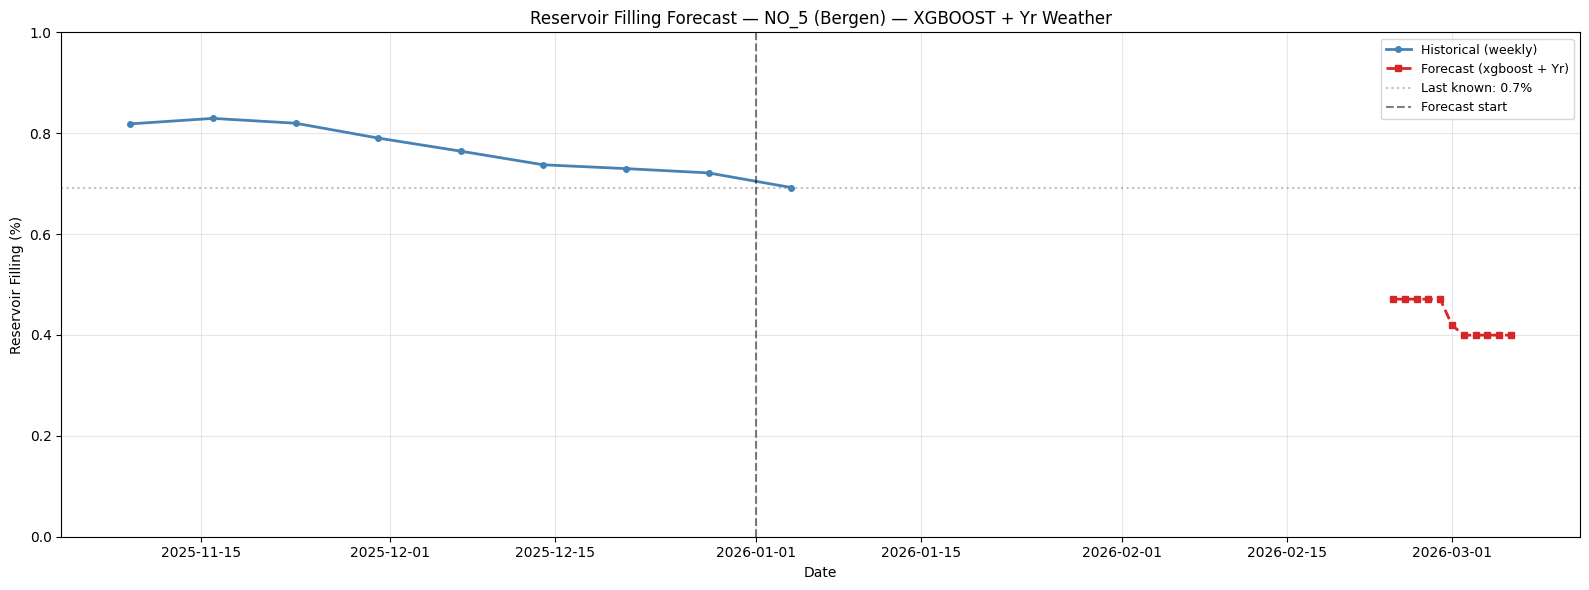


Daily forecast:
  2026-02-24 (Tue): 0.5%
  2026-02-25 (Wed): 0.5%
  2026-02-26 (Thu): 0.5%
  2026-02-27 (Fri): 0.5%
  2026-02-28 (Sat): 0.5%
  2026-03-01 (Sun): 0.4%
  2026-03-02 (Mon): 0.4%
  2026-03-03 (Tue): 0.4%
  2026-03-04 (Wed): 0.4%
  2026-03-05 (Thu): 0.4%
  2026-03-06 (Fri): 0.4%


In [15]:
import holidays as holidays_lib

# Fetch Yr weather forecast
yr_df = fetch_yr_forecast(ZONE, cache=True)

if not yr_df.empty:
    print(f"Yr forecast for {ZONE}: {len(yr_df)} hours")
    print(f"Range: {yr_df.index.min()} to {yr_df.index.max()}")

    # Use the best individual model
    best_ml_model = {
        "xgboost": xgb_model,
        "lightgbm": lgbm_model,
        "catboost": cat_model,
    }[best_model_type]

    # Build forward feature matrix
    forecast_index = yr_df.index
    feature_cols = best_ml_model.feature_names_

    # Template from last known features
    template = df[feature_cols].iloc[-1:]
    X_future = pd.DataFrame(
        np.tile(template.values, (len(forecast_index), 1)),
        columns=feature_cols,
        index=forecast_index,
    )

    # Override calendar features
    no_hol = holidays_lib.Norway()
    cal_map = {
        "hour_of_day": forecast_index.hour,
        "day_of_week": forecast_index.dayofweek,
        "month": forecast_index.month,
        "week_of_year": forecast_index.isocalendar().week.values,
        "is_weekend": (forecast_index.dayofweek >= 5).astype(int),
        "is_holiday": pd.Series(
            [int(d in no_hol) for d in forecast_index.date],
            index=forecast_index,
        ),
        "is_business_hour": (
            (forecast_index.hour >= 8)
            & (forecast_index.hour <= 17)
            & (forecast_index.dayofweek < 5)
        ).astype(int),
    }
    for col, values in cal_map.items():
        if col in X_future.columns:
            X_future[col] = values

    # Override weather with Yr forecast
    yr_to_hist = {
        "yr_temperature": "temperature",
        "yr_wind_speed": "wind_speed",
        "yr_precipitation_1h": "precipitation",
        "yr_cloud_cover": "cloud_cover",
        "yr_humidity": "humidity",
        "yr_pressure": "pressure",
    }
    for yr_col, hist_col in yr_to_hist.items():
        if hist_col in X_future.columns and yr_col in yr_df.columns:
            aligned = yr_df[yr_col].reindex(forecast_index)
            X_future[hist_col] = aligned

    # Predict reservoir filling
    reservoir_pred = best_ml_model.predict(X_future)
    # Clip to valid range [0, 100]
    reservoir_pred = reservoir_pred.clip(0, 1)

    print(f"\nForward forecast ({best_model_type}):")
    print(f"  Hours: {len(reservoir_pred)}")
    print(f"  Mean filling: {reservoir_pred.mean():.1f}%")
    print(f"  Range: {reservoir_pred.min():.1f}% to {reservoir_pred.max():.1f}%")

    # Daily average for display
    daily_pred = reservoir_pred.resample("D").mean()
    daily_pred = daily_pred[daily_pred.notna()]

    # Plot: recent history + forward forecast
    fig, ax = plt.subplots(figsize=(16, 6))

    # Last 8 weeks of history (weekly)
    recent = target.iloc[-8 * 168:]
    recent_weekly = recent.resample("W").mean()
    ax.plot(recent_weekly.index, recent_weekly.values,
            color="steelblue", linewidth=2, marker="o", markersize=4,
            label="Historical (weekly)")

    # Forward forecast (daily for more detail)
    ax.plot(daily_pred.index, daily_pred.values,
            color="tab:red", linewidth=2, marker="s", markersize=4,
            linestyle="--", label=f"Forecast ({best_model_type} + Yr)")

    # Last known value reference
    last_known = target.iloc[-1]
    ax.axhline(last_known, color="gray", linestyle=":", alpha=0.5,
               label=f"Last known: {last_known:.1f}%")

    # Forecast boundary
    ax.axvline(target.index[-1], color="black", linestyle="--", alpha=0.5,
               label="Forecast start")

    ax.set_xlabel("Date")
    ax.set_ylabel("Reservoir Filling (%)")
    ax.set_title(f"Reservoir Filling Forecast — {ZONE} (Bergen) — {best_model_type.upper()} + Yr Weather")
    ax.set_ylim(0, 1)
    ax.legend(loc="best", fontsize=9)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Summary table
    print(f"\nDaily forecast:")
    for date, val in daily_pred.items():
        print(f"  {date.strftime('%Y-%m-%d (%a)')}: {val:.1f}%")
else:
    print("Yr forecast fetch failed — skipping forward forecast.")
    reservoir_pred = pd.Series(dtype=float)

## 8. Key Findings

In [16]:
# Grand comparison table
comp = comparison_table(all_results)

print("=" * 80)
print(f"RESERVOIR FILLING FORECAST SUMMARY — {ZONE} (Bergen)")
print("=" * 80)

print(f"\nTarget: {TARGET_COL} (0-100%, weekly data forward-filled to hourly)")
print(f"Validation period: {y_val.index.min().date()} to {y_val.index.max().date()}")
print(f"Features used: {X_train_full.shape[1]} (leakage columns removed: {LEAKAGE_COLS})")

print(f"\n--- Final Rankings (MAE in percentage points) ---")
display(comp)

# EUR/NOK for context
latest_eur_nok = df["eur_nok"].dropna().iloc[-1]

# Key results
best_method = comp.iloc[0]["Method"]
best_mae = comp.iloc[0]["mae"]
naive_mae = naive_metrics["mae"]

print(f"\n--- Key Results ---")
print(f"Best model: {best_method}")
print(f"  MAE: {best_mae:.2f} percentage points")
print(f"  vs Naive ({naive_mae:.2f} pp): {(1 - best_mae/naive_mae)*100:.1f}% improvement")

print(f"\n--- Top Features (SHAP) ---")
for i, (feat, val) in enumerate(mean_abs_shap.head(5).items(), 1):
    print(f"  {i}. {feat} (SHAP: {val:.4f} pp)")

if not yr_df.empty and len(reservoir_pred) > 0:
    print(f"\n--- Forward Forecast ---")
    print(f"  Horizon: {len(reservoir_pred)} hours ({reservoir_pred.index.min().date()} to {reservoir_pred.index.max().date()})")
    print(f"  Last known filling: {target.iloc[-1]:.1f}%")
    print(f"  Predicted mean: {reservoir_pred.mean():.1f}%")
    print(f"  Predicted range: {reservoir_pred.min():.1f}% to {reservoir_pred.max():.1f}%")

print(f"\n--- Walk-Forward Validation ({best_model_type}) ---")
print(f"  {len(wf_results)} folds, MAE: {np.mean(mae_values):.2f} +/- {np.std(mae_values):.2f} pp")

print("\n" + "-" * 80)
print("Observations:")
print("-" * 80)
print("1. Reservoir filling follows a strong annual cycle (spring fill, winter depletion).")
print("   The naive baseline (same week last year) is a strong benchmark.")
print("2. ML models improve on naive by learning year-to-year variations in")
print("   precipitation, temperature, and production patterns.")
print("3. SHAP analysis should confirm that season (month/week), temperature,")
print("   and precipitation are the primary drivers — consistent with physics.")
print("4. Reservoir changes slowly (weekly updates), so hourly predictions")
print("   are relatively flat within each week. The key signal is the")
print("   week-over-week trend direction and magnitude.")
print("5. Forward forecast using Yr weather gives ~9 days of predictions,")
print("   but accuracy degrades with longer horizons.")
print("")
print("Next steps:")
print("- 09c: Demand forecasting (consumption patterns)")
print("- 09d: Production forecasting (generation by type)")
print("- 09e: Trade flow forecasting (net import/export)")
print("- 09f: Multi-target VAR integration")

RESERVOIR FILLING FORECAST SUMMARY — NO_5 (Bergen)

Target: reservoir_filling_pct (0-100%, weekly data forward-filled to hourly)
Validation period: 2025-01-01 to 2025-06-30
Features used: 32 (leakage columns removed: ['reservoir_filling_twh', 'reservoir_filling_change', 'reservoir_vs_median', 'reservoir_vs_min'])

--- Final Rankings (MAE in percentage points) ---


,Method,mae,rmse,mape,directional_accuracy,peak_hour_mae,fit_time_s,skill_score
Rank,,,,,,,,
1,XGBoost,0.032,0.045,6.38,0.4,0.032,0.2,0.738
2,LightGBM,0.033,0.046,6.52,0.3,0.033,0.8,0.734
3,Ensemble (weighted),0.035,0.050,6.77,0.3,0.035,0.0,0.716
4,Ensemble (simple avg),0.036,0.052,6.98,0.3,0.037,0.0,0.706
5,CatBoost,0.049,0.069,9.34,0.1,0.049,0.3,0.603
6,Naive (same week last year),0.124,0.130,30.38,0.5,0.124,0.0,NaN



--- Key Results ---
Best model: XGBoost
  MAE: 0.03 percentage points
  vs Naive (0.12 pp): 74.2% improvement

--- Top Features (SHAP) ---
  1. week_of_year (SHAP: 0.0550 pp)
  2. month (SHAP: 0.0489 pp)
  3. eur_nok (SHAP: 0.0103 pp)
  4. brent_oil_close (SHAP: 0.0095 pp)
  5. ttf_gas_close (SHAP: 0.0092 pp)

--- Forward Forecast ---
  Horizon: 239 hours (2026-02-24 to 2026-03-06)
  Last known filling: 0.7%
  Predicted mean: 0.4%
  Predicted range: 0.4% to 0.5%

--- Walk-Forward Validation (xgboost) ---
  6 folds, MAE: 0.01 +/- 0.00 pp

--------------------------------------------------------------------------------
Observations:
--------------------------------------------------------------------------------
1. Reservoir filling follows a strong annual cycle (spring fill, winter depletion).
   The naive baseline (same week last year) is a strong benchmark.
2. ML models improve on naive by learning year-to-year variations in
   precipitation, temperature, and production patterns.
3. 